# Project 1 - Exploratory Data Analysis for Machine Learning
This notebook is a part of my first project required by IBM Machine Learning Program.

Data source: [Board Games - Tidy Tuesday](https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-03-12)

In this notebook, the data will be cleaned and the relationship between the target (game average rating) and potential predictors will be explored. In addition, new features from the existing data will be constructed and hypothesis tests will be performed.

Notebook Contents:
> 1. Data Overview
> 2. Data Cleaning and Feature Engineering: Categorical Data
> 3. Data Cleaning and Feature Engineering: Numeric Data
> 4. Hypothesis Testing

## 1. Data Overview

In [1]:
# Wrangling
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Cluster
from sklearn.cluster import KMeans
sns.set()
%matplotlib inline
np.warnings.filterwarnings('ignore')

In [2]:
# Load in the dataset
data = pd.read_csv('board_games.csv')
print(data.shape)
data.describe().T


(10532, 22)


,count,mean,std,min,25%,50%,75%,max
game_id,10532.0,62059.203095,66223.716828,1.00000,5444.500000,28822.500000,126409.500000,216725.00000
max_players,10532.0,5.657330,18.884403,0.00000,4.000000,4.000000,6.000000,999.00000
max_playtime,10532.0,91.341436,659.754400,0.00000,30.000000,45.000000,90.000000,60000.00000
min_age,10532.0,9.714964,3.451226,0.00000,8.000000,10.000000,12.000000,42.00000
min_players,10532.0,2.070547,0.664394,0.00000,2.000000,2.000000,2.000000,9.00000
min_playtime,10532.0,80.882738,637.873893,0.00000,25.000000,45.000000,90.000000,60000.00000
playing_time,10532.0,91.341436,659.754400,0.00000,30.000000,45.000000,90.000000,60000.00000
year_published,10532.0,2003.070832,12.278296,1950.00000,1998.000000,2007.000000,2012.000000,2016.00000
average_rating,10532.0,6.370856,0.850364,1.38421,5.829585,6.392965,6.942675,9.00392
users_rated,10532.0,870.081466,2880.214998,50.00000,85.000000,176.000000,518.000000,67655.00000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532 entries, 0 to 10531
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   game_id         10532 non-null  int64  
 1   description     10532 non-null  object 
 2   image           10531 non-null  object 
 3   max_players     10532 non-null  int64  
 4   max_playtime    10532 non-null  int64  
 5   min_age         10532 non-null  int64  
 6   min_players     10532 non-null  int64  
 7   min_playtime    10532 non-null  int64  
 8   name            10532 non-null  object 
 9   playing_time    10532 non-null  int64  
 10  thumbnail       10531 non-null  object 
 11  year_published  10532 non-null  int64  
 12  artist          7759 non-null   object 
 13  category        10438 non-null  object 
 14  compilation     410 non-null    object 
 15  designer        10406 non-null  object 
 16  expansion       2752 non-null   object 
 17  family          7724 non-null  

There aren't any duplicates


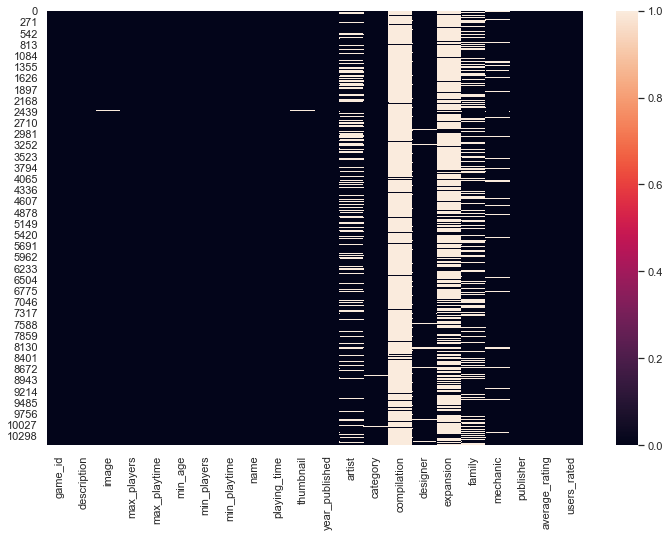

In [4]:
# Duplicates check
if data.duplicated().any() == False:
    print("There aren't any duplicates")
else:
    print('There are suplicates')

fig, ax = plt.subplots(figsize=(12,8))
# Nulls check
sns.heatmap(data.isnull(), ax = ax)
plt.show()

In [5]:
data.isnull().sum().sort_values()

game_id               0
year_published        0
average_rating        0
playing_time          0
name                  0
min_playtime          0
users_rated           0
min_age               0
max_playtime          0
max_players           0
description           0
min_players           0
image                 1
thumbnail             1
publisher             3
category             94
designer            126
mechanic            950
artist             2773
family             2808
expansion          7780
compilation       10122
dtype: int64

## 2. Data Cleaning and Feature Engineering: Categorical Data

In [6]:
# Have a look at all categorical variables
data.describe(include='object').T

,count,unique,top,freq
description,10532,10528,How could that have happened? Black Stories ar...,3
image,10531,10527,//cf.geekdo-images.com/images/pic2578828.png,2
name,10532,10357,Robin Hood,5
thumbnail,10531,10527,//cf.geekdo-images.com/images/pic2262580_t.png,2
artist,7759,4641,Franz Vohwinkel,166
category,10438,3860,"Wargame,World War II",449
compilation,410,336,"Traveller: The Classic Games, Games 1-6+",8
designer,10406,4678,(Uncredited),558
expansion,2752,2634,Last Battles of Napoleon,7
family,7724,3918,Crowdfunding: Kickstarter,391


In [7]:
data_dict ={}
data_dict['Variable Name'] = data.columns
data_dict['Type'] = data.dtypes
data_dframe = pd.DataFrame.from_dict(data_dict)

data_dframe.to_excel("data_description.xlsx")

In [8]:
# Remove features that have too many missing values or those that can't help discriminate the target
data.drop(['game_id', 'description', 'image', 'name',
         'thumbnail', 'family', 'expansion', 'compilation'],
         axis=1, inplace=True)


### Counts derived from category aggregates

In [9]:
# Select categorical variable names
category_cols = data.select_dtypes(np.object).columns

# Iterate through each column and count unique values
for cat in category_cols:
    num_unique_values = len(set(','.join(data[cat].dropna()).replace(', ', ',').split(',')))
    print(f'Number of unique values of {cat}:\t\t{num_unique_values}')

Number of unique values of artist:		6137
Number of unique values of category:		83
Number of unique values of designer:		5119
Number of unique values of mechanic:		51
Number of unique values of publisher:		3366


In [10]:
# Count values in each categorical variable of each game
for cat in category_cols:
    data['num_' + cat] = [np.nan if x is np.nan 
                               else len(x) + 1 
                               for x in data[cat].str.findall(',')]

# Drop multi-level categorical variables
data.drop(['artist', 'designer', 'publisher'], axis=1, inplace=True)

In [11]:
# Drop rows that have missing values
data.dropna(inplace=True)

# Current data shape
data.shape

(7151, 16)

Within a row, each categorical variable contains multiple values. I will transform these data to dummies.

### Categories derived from category aggregates

- Get a set of all unique values in each variable
- Create new columns based on these values
- Iterate through all rows and fill in dummy values for each new column
- Group these dummy variables if possible 

In [12]:
# Create functions
def value_list(data: pd.DataFrame, col: str) -> list:
    """ Returns a list of unique values that included in a given column
    """
    # Join all values in the column then get a set of them
    value_set = set(','.join(data[col].dropna()).replace(', ', ',').split(','))

    # Make all string lower case for processing purpose
    repr_list = [x.lower() for x in list(value_set)]

    return repr_list

def create_dummies(data: pd.DataFrame, col: str, key_word: str) -> list:
    """ Creates dummies for a given category in a column
    """
    word_list = [1 if (x is not np.nan) and (key_word in str(x).lower())
                 else 0 if (x is not np.nan) and (key_word not in str(x).lower())
                 else np.nan for x in data[col]]
    return word_list


def dummy_loop(data: pd.DataFrame, col: str) -> pd.DataFrame:
    """ Returns a data frame of dummies 
    """
    # Iterate through columns
    for value in value_list(data, col):
        data[col + '_' + value] = create_dummies(data=data, col=col, key_word=value)
    
    # Drop the original columns
    data.drop(col, axis=1, inplace=True)
    return data

In [13]:
# Print out game categories
value_list(data, 'category')

['adventure',
 'american civil war',
 'trains',
 'collectible components',
 'arabian',
 'travel',
 'medieval',
 'civilization',
 'farming',
 'ancient',
 'print & play',
 'real-time',
 'vietnam war',
 'aviation / flight',
 'word game',
 'sports',
 'abstract strategy',
 'novel-based',
 'transportation',
 'space exploration',
 'economic',
 'territory building',
 'educational',
 'puzzle',
 'humor',
 'party game',
 'deduction',
 'mafia',
 'napoleonic',
 'industry / manufacturing',
 'pirates',
 'nautical',
 'murder/mystery',
 'age of reason',
 'exploration',
 'american west',
 'zombies',
 'wargame',
 'maze',
 'math',
 'world war i',
 'trivia',
 'miniatures',
 'mythology',
 'prehistoric',
 'city building',
 'comic book / strip',
 'korean war',
 'political',
 'science fiction',
 'mature / adult',
 'expansion for base-game',
 'world war ii',
 'spies/secret agents',
 'book',
 'modern warfare',
 'renaissance',
 'negotiation',
 'fantasy',
 'game system',
 'post-napoleonic',
 'movies / tv / radio t

In [14]:
# Print out game mechanics
value_list(data, 'mechanic')

['point to point movement',
 'storytelling',
 'modular board',
 'roll / spin and move',
 'trick-taking',
 'action point allowance system',
 'acting',
 'commodity speculation',
 'hand management',
 'simultaneous action selection',
 'time track',
 'card drafting',
 'area-impulse',
 'dice rolling',
 'pattern building',
 'memory',
 'singing',
 'voting',
 'campaign / battle card driven',
 'line drawing',
 'betting/wagering',
 'tile placement',
 'press your luck',
 'secret unit deployment',
 'area control / area influence',
 'route/network building',
 'rock-paper-scissors',
 'auction/bidding',
 'chit-pull system',
 'variable phase order',
 'area movement',
 'action / movement programming',
 'co-operative play',
 'pick-up and deliver',
 'role playing',
 'deck / pool building',
 'player elimination',
 'grid movement',
 'partnerships',
 'take that',
 'worker placement',
 'area enclosure',
 'crayon rail system',
 'variable player powers',
 'hex-and-counter',
 'trading',
 'simulation',
 'pattern 

In [15]:
data.shape

(7151, 16)

In [16]:
# Apply functions to get dummies
df = dummy_loop(dummy_loop(data, 'category'), 'mechanic')

# Print out first 5 rows
df.head()

,max_players,max_playtime,min_age,min_players,min_playtime,playing_time,year_published,average_rating,users_rated,num_artist,...,mechanic_area enclosure,mechanic_crayon rail system,mechanic_variable player powers,mechanic_hex-and-counter,mechanic_trading,mechanic_simulation,mechanic_pattern recognition,mechanic_paper-and-pencil,mechanic_set collection,mechanic_stock holding
0,5,240,14,3,240,240,1986,7.66508,4498,1.0,...,0,0,0,0,0,0,0,0,0,0
1,4,30,12,3,30,30,1981,6.60815,478,1.0,...,0,0,0,0,0,0,0,0,0,0
2,4,60,10,2,30,60,1998,7.44119,12019,1.0,...,0,0,0,0,0,0,0,0,1,0
4,6,90,12,3,90,90,1964,7.35830,15195,2.0,...,0,0,0,0,0,0,0,0,0,1
5,6,240,12,2,240,240,1989,6.52534,73,1.0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df.shape

(7151, 148)

In [18]:
# Check number of game categories
game_categories = df.filter(regex='^category_', axis=1)
game_categories.columns

Index(['category_adventure', 'category_american civil war', 'category_trains',
       'category_collectible components', 'category_arabian',
       'category_travel', 'category_medieval', 'category_civilization',
       'category_farming', 'category_ancient', 'category_print & play',
       'category_real-time', 'category_vietnam war',
       'category_aviation / flight', 'category_word game', 'category_sports',
       'category_abstract strategy', 'category_novel-based',
       'category_transportation', 'category_space exploration',
       'category_economic', 'category_territory building',
       'category_educational', 'category_puzzle', 'category_humor',
       'category_party game', 'category_deduction', 'category_mafia',
       'category_napoleonic', 'category_industry / manufacturing',
       'category_pirates', 'category_nautical', 'category_murder/mystery',
       'category_age of reason', 'category_exploration',
       'category_american west', 'category_zombies', 'category_

In [19]:
# Group categories based on BGG wiki
activity_categories = ['category_city building', 'category_civilization',
                       'category_educational', 'category_puzzle',
                       'category_racing', 'category_territory building',
                       'category_transportation']

component_categories = ['category_card game', 'category_collectible components',
                        'category_dice', 'category_electronic',
                        'category_miniatures']

nongame_categories = ['category_book', 'category_expansion for base-game',
                      'category_game system']

war_categories = list(df.filter(regex='war', axis=1).columns)
war_categories = war_categories + ['category_napoleonic', 'category_post-napoleonic',
                                   'category_pike and shot']

skills_categories = ['category_action / dexterity', 'category_bluffing',
                     'category_deduction', 'category_economic',
                     'category_math', 'category_number',
                     'category_memory', 'category_negotiation',
                     'category_real-time', 'category_spatial analysis',
                     'category_trivia', 'category_word game']

entertainment_categories = ['category_comic book / strip', 'category_movies / tv / radio theme',
                            'category_music', 'category_novel-based',
                            'category_video game theme']

nongroup_categories = ['category_party game', 'category_abstract strategy',
                       "category_children's game"]

In [20]:
# Create functions
def dummy_group(data: pd.DataFrame, category: list) -> list:
    """
    Returns a list of dummies derived from input category
    """
    for i in category:
        if i not in list(data.columns):
            category.remove(i)
    dummies = [1 if x >= 1 else 0 for x in data[category].sum(axis=1)]
    data.drop(category, axis=1, inplace=True)
    return dummies

def plot_bar(data: pd.DataFrame,
             prefix: str, figsize: tuple,
             title: str, filename: str):
    category_df = (data
                   .filter(regex=prefix, axis=1)
                   .sum()
                   .to_frame('count')
                   .sort_values('count')
    )
    ax = category_df.plot.barh(legend=None, figsize=figsize, linewidth=0)
    ax.set_yticklabels(list(category_df.sort_values('count').index.str.replace(prefix,'')))
    ax.tick_params(labelsize=12)
    ax.set_title(title, fontsize=16)
    plt.savefig(filename)

In [21]:
# Apply dummy function to each category
df['category_activity'] = dummy_group(df, activity_categories)
df['category_component'] = dummy_group(df, component_categories)
df['category_nongame'] = dummy_group(df, nongame_categories)
df['category_war'] = dummy_group(df, war_categories)
df['category_skills'] = dummy_group(df, skills_categories)
df['category_entertainment'] = dummy_group(df, entertainment_categories)

# Select games only
df = df[df['category_nongame'] == 0]
df.drop('category_nongame', axis=1, inplace=True)

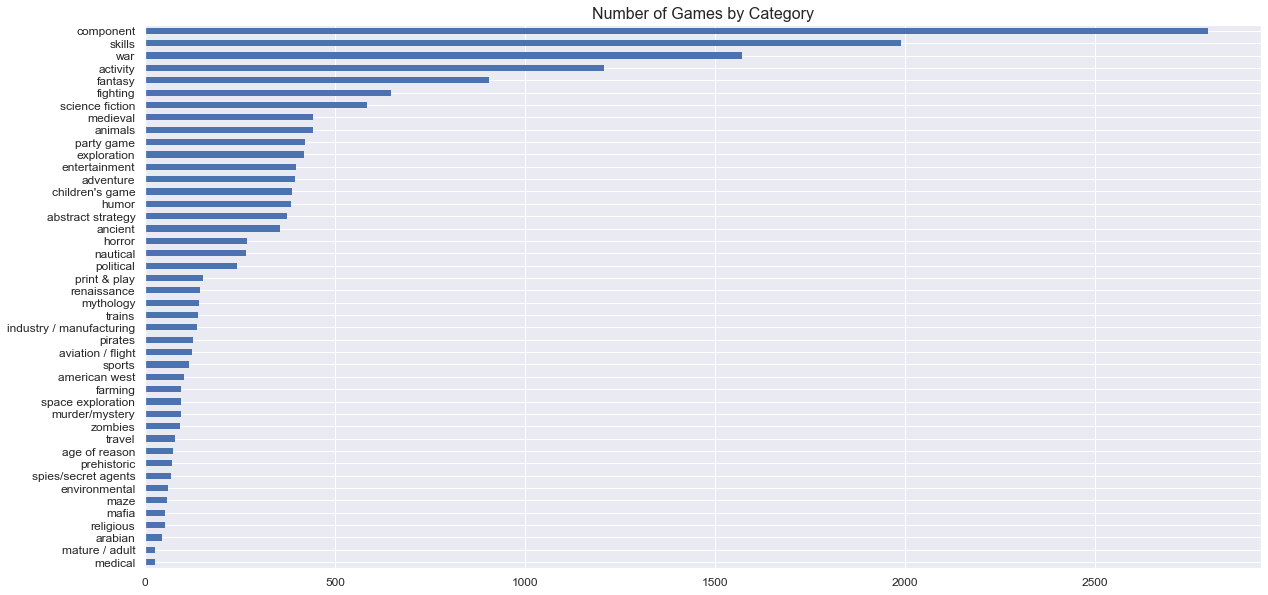

In [22]:
plot_bar(data=df,
         prefix='category_',
         figsize=(20,10),
         title='Number of Games by Category', filename = "Game_by_Category.png")

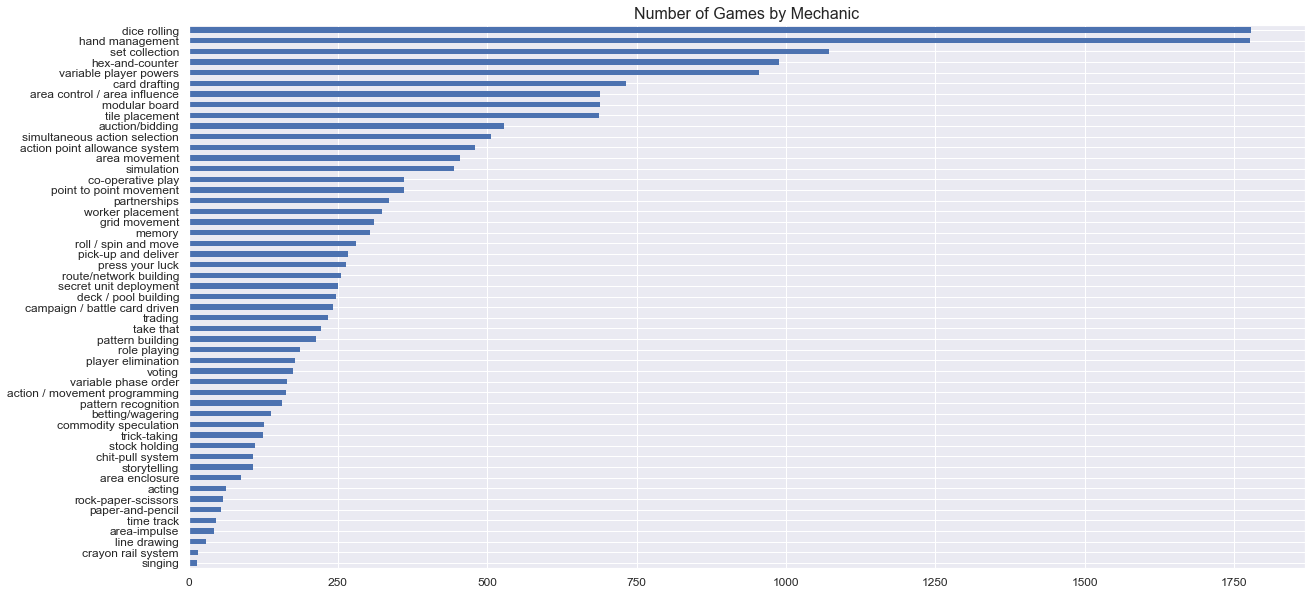

In [23]:
plot_bar(data=df,
         prefix='mechanic_',
         figsize=(20,10),
         title='Number of Games by Mechanic', filename = "Game_by_Mechanic.png")

In [24]:
# Current data shape
df.shape

(7031, 109)

## 3. Data Cleaning and Engineering: Numeric Data

In [25]:
# Select numeric data that are not binary
numeric_df = data.loc[:, ~data.isin([0,1]).all()]
numeric_df.shape

(7151, 14)

In [26]:
# Some statistics
numeric_df.describe()

,max_players,max_playtime,min_age,min_players,min_playtime,playing_time,year_published,average_rating,users_rated,num_artist,num_category,num_designer,num_mechanic,num_publisher
count,7151.000000,7151.000000,7151.000000,7151.000000,7151.000000,7151.000000,7151.000000,7151.000000,7151.000000,7151.000000,7151.000000,7151.000000,7151.000000,7151.000000
mean,5.038736,104.344288,9.994267,2.058314,90.235911,104.344288,2004.751503,6.549940,1157.467487,2.225563,2.667179,1.411551,2.623409,2.847294
std,7.475183,786.222171,3.260245,0.671777,759.596494,786.222171,11.337674,0.771438,3433.360647,7.228548,1.328119,0.810405,1.531526,4.019937
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1951.000000,2.339400,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,30.000000,8.000000,2.000000,30.000000,30.000000,2001.000000,6.056285,101.000000,1.000000,2.000000,1.000000,1.000000,1.000000
50%,4.000000,45.000000,10.000000,2.000000,45.000000,45.000000,2009.000000,6.549100,237.000000,1.000000,2.000000,1.000000,2.000000,2.000000
75%,6.000000,90.000000,12.000000,2.000000,90.000000,90.000000,2013.000000,7.062480,763.000000,2.000000,3.000000,2.000000,3.000000,3.000000
max,362.000000,60000.000000,25.000000,9.000000,60000.000000,60000.000000,2016.000000,9.003920,67655.000000,510.000000,14.000000,11.000000,18.000000,157.000000


In [27]:
# Select non zero rows only
df = df[(df.iloc[:,:6] > 0).all(axis=1)]

In [28]:
# Create game age variable from year published
df['game_age'] = 2019 - df['year_published']

# Drop unuseful columns
df.drop(['max_playtime', 'min_playtime', 'users_rated'], axis=1, inplace=True)

In [29]:
# Select data again
numeric_df = df.loc[:, ~df.isin([0,1]).all()]

# Current data shape
numeric_df.shape

(6584, 12)

In [30]:
# Check statistics again
numeric_df.describe()

,max_players,min_age,min_players,playing_time,year_published,average_rating,num_artist,num_category,num_designer,num_mechanic,num_publisher,game_age
count,6584.000000,6584.000000,6584.000000,6584.000000,6584.000000,6584.000000,6584.000000,6584.000000,6584.000000,6584.000000,6584.000000,6584.000000
mean,5.063335,10.480711,2.068348,101.519289,2004.577612,6.528923,2.216130,2.655225,1.398542,2.638366,2.914034,14.422388
std,7.279980,2.427485,0.663408,785.037892,11.432093,0.757773,7.446721,1.322710,0.787282,1.528202,3.653356,11.432093
min,1.000000,2.000000,1.000000,1.000000,1951.000000,2.339400,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,4.000000,8.000000,2.000000,30.000000,2000.000000,6.044215,1.000000,2.000000,1.000000,1.000000,1.000000,6.000000
50%,4.000000,10.000000,2.000000,50.000000,2009.000000,6.527770,1.000000,2.000000,1.000000,2.000000,2.000000,10.000000
75%,6.000000,12.000000,2.000000,90.000000,2013.000000,7.027945,2.000000,3.000000,2.000000,3.000000,3.000000,19.000000
max,362.000000,25.000000,9.000000,60000.000000,2016.000000,9.003920,510.000000,14.000000,11.000000,18.000000,92.000000,68.000000


In [31]:
# Create a functions to plot multiple bar charts
def hist_loop(data: pd.DataFrame,
              rows: int,
              cols: int,
              figsize: tuple, filename: str):
    fig, axes = plt.subplots(rows,cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(data.columns):
            data[sorted(data.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{sorted(data.columns)[i]} distribution', fontsize=16)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.get_yaxis().get_label().set_visible(False)
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()
    fig.savefig(filename)

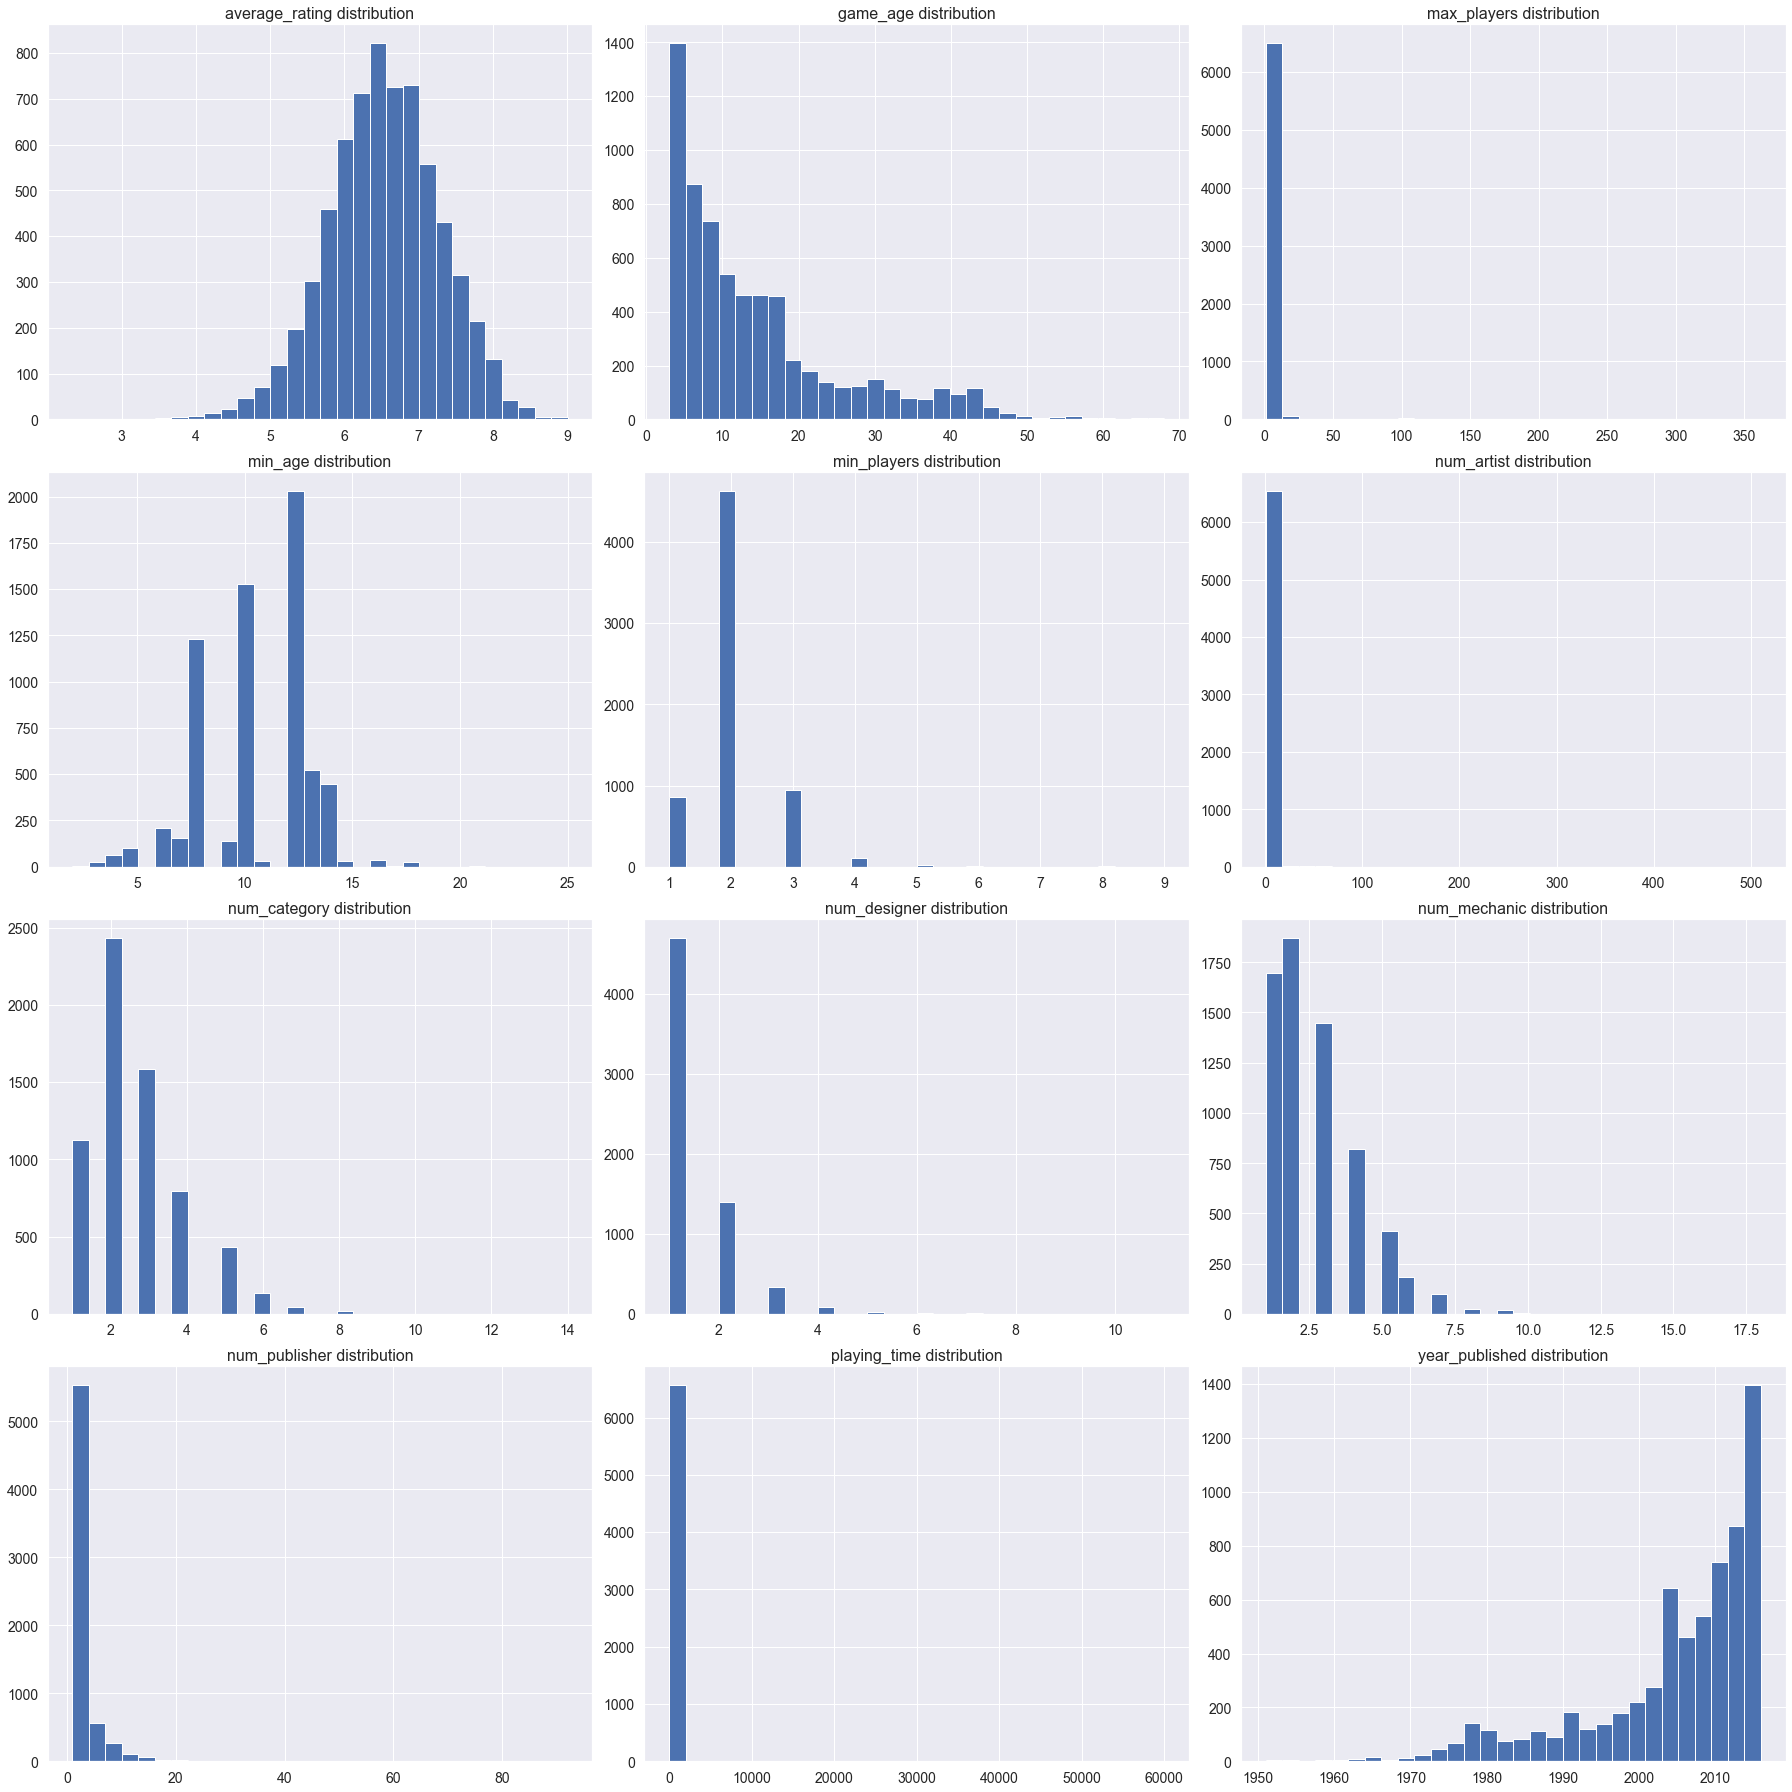

In [32]:
hist_loop(data=numeric_df,
          rows=4,
          cols=3,
          figsize=(25,25), filename="numeric_hist_plot.png")

In [33]:
# Create a function to check skewness
def skew_df(data: pd.DataFrame, skew_limit: float) -> pd.DataFrame:
    # Define a limit above which we will log transform
    skew_vals = data.skew()

    # Showing the skewed columns
    skew_cols = (skew_vals
                 .sort_values(ascending=False)
                 .to_frame('Skew')
                 .query('abs(Skew) > {}'.format(skew_limit))
    )
    return skew_cols

In [34]:
# Print out skewed columns
skew_cols = skew_df(numeric_df, 0.75)
skew_cols

,Skew
playing_time,68.411976
num_artist,51.035546
max_players,24.297285
num_publisher,6.934435
num_designer,3.338446
min_players,1.956752
game_age,1.447219
num_mechanic,1.284675
num_category,1.127978
year_published,-1.447219


### Log transformation for skewed variables

In [35]:
# Perform log transformation
for col in skew_cols.index.values:
    numeric_df['log_' + col] = numeric_df[col].apply(np.log1p)
    
# Check skewness on log transformed data
log_df = numeric_df.filter(regex='^log_', axis=1)
skew_log_cols = skew_df(log_df, 0.75)
skew_log_cols

,Skew
log_num_artist,2.493956
log_num_designer,1.803937
log_num_publisher,1.314687
log_max_players,1.305299
log_year_published,-1.461026


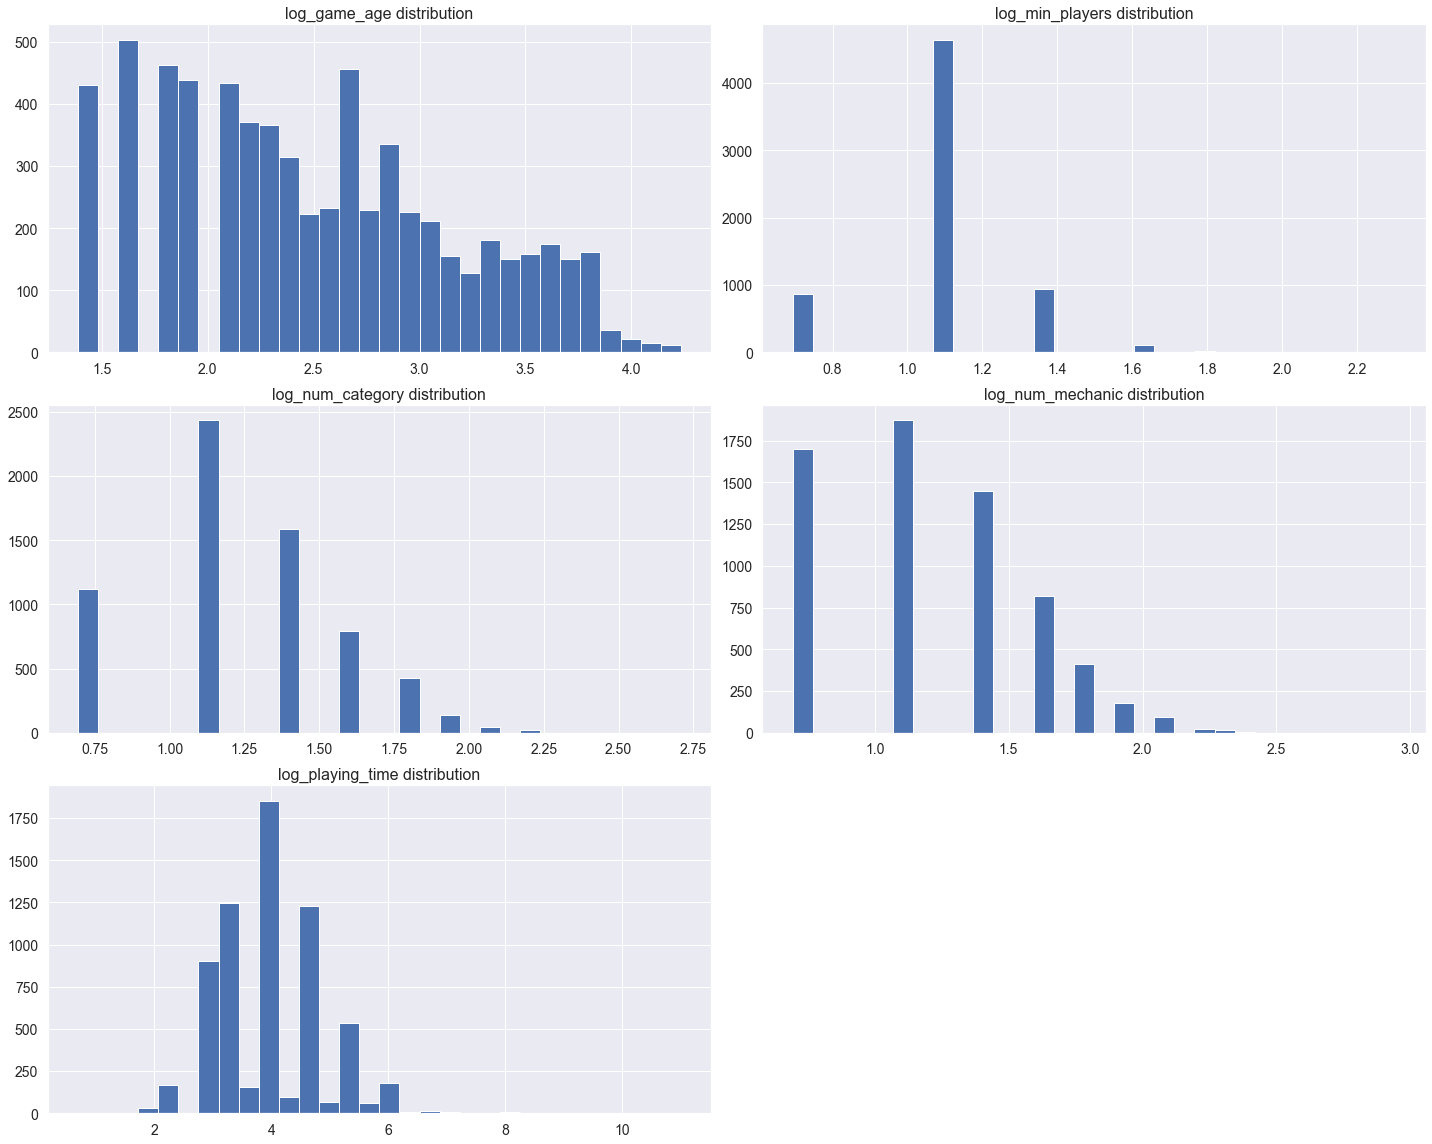

In [36]:
# Plot log columns that have nearly normal distribution
log_df = log_df.drop(skew_log_cols.index, axis=1)
hist_loop(data=log_df.copy(),
          rows=3,
          cols=2,
          figsize=(20,16), filename="log_skew_hist_plot.png")

In [37]:
# Join these new columns to our dataset
df = df.join(log_df).drop([x.replace('log_', '') for x in log_df.columns], axis=1)

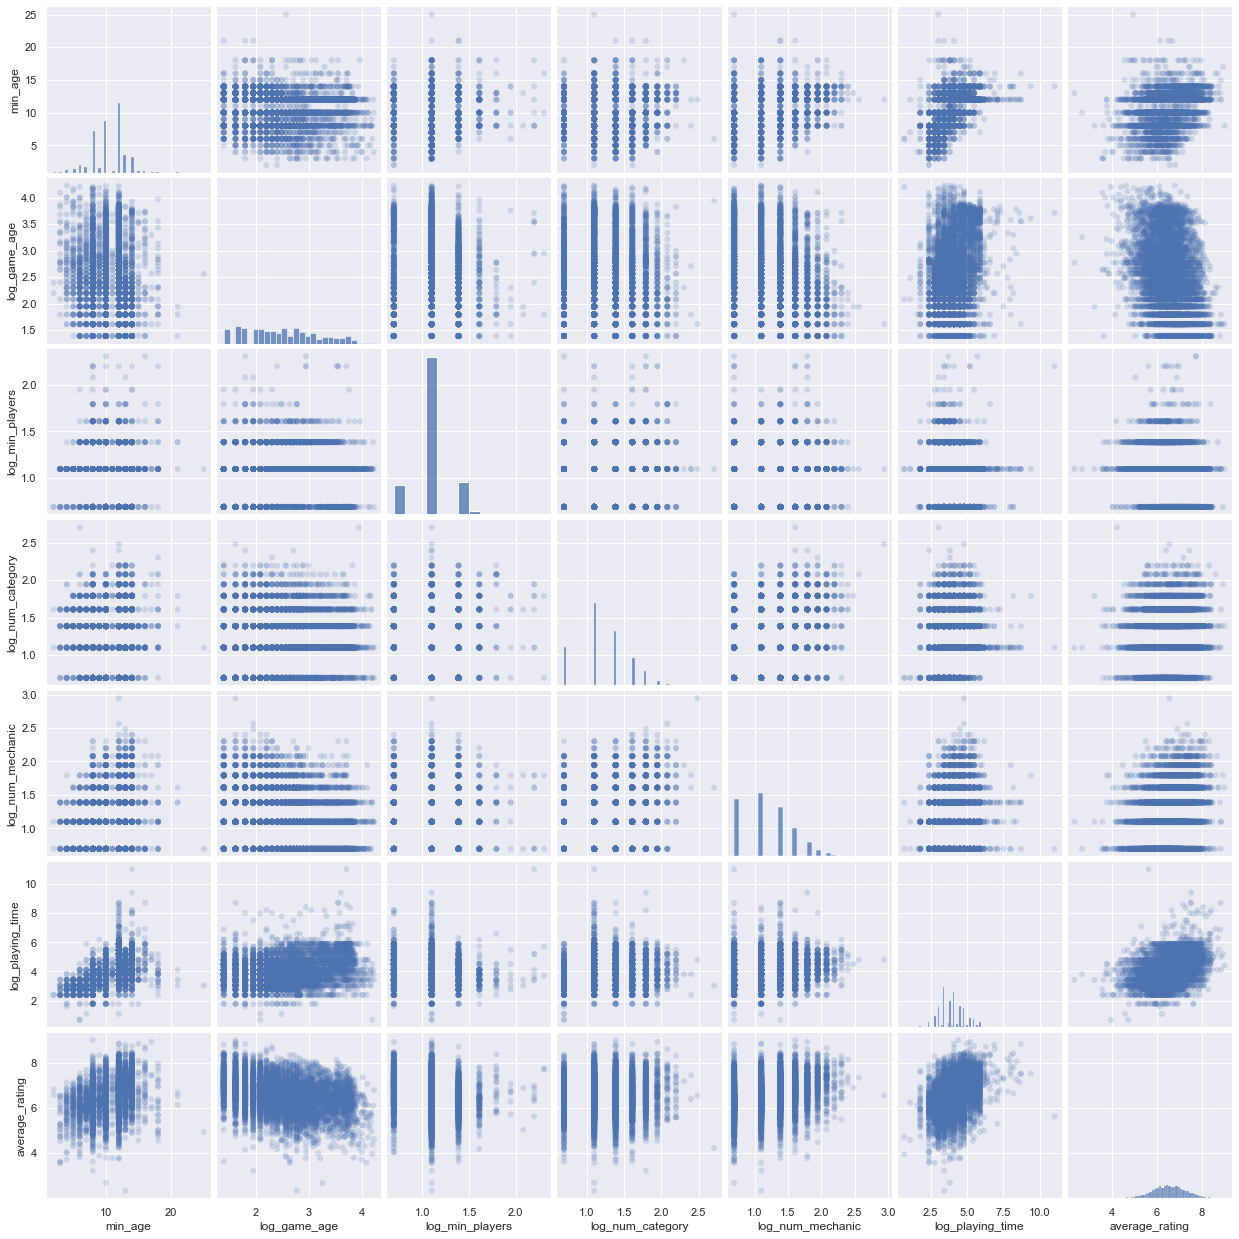

In [38]:
# Pairplot of numeric data
sns.pairplot(data=df, vars=['min_age', 'log_game_age', 'log_min_players', 'log_num_category',
                            'log_num_mechanic', 'log_playing_time', 'average_rating'],
             plot_kws=dict(alpha=.2, edgecolor='none'));
plt.savefig("pairplot_data.png")

Observations from this plot:
- The target (average_rating) has a normal distribution.
- No strong linear relationship between the features and the target. Linear regression might not be well-suited to this problem.
- There might be a relationship between minimum age and playing time.
- I can try adding polynomial and interaction terms and examine their correlation with the target.

### Adding polynomial and interaction terms

In [39]:
from sklearn.preprocessing import PolynomialFeatures

# Instantiate and provide desired degree; 
# Note: degree=2 also includes intercept, degree 1 terms, and cross-terms
pf = PolynomialFeatures(degree=2)

In [40]:
# Select features
feature_cols = ['min_age', 'log_game_age', 'log_min_players', 'log_num_category',
                'log_num_mechanic', 'log_playing_time']
features = df[feature_cols]

# fit and transform
pf.fit(features)
feat_array = pf.transform(features)

# Create a data frame
feat_df = pd.DataFrame(feat_array,
                       index=df.index,
                       columns=pf.get_feature_names(input_features=features.columns))

# Drop the intercept
feat_df.drop('1', axis=1, inplace=True)

# Add in the target
feat_df.insert(0, 'average_rating', df['average_rating'])

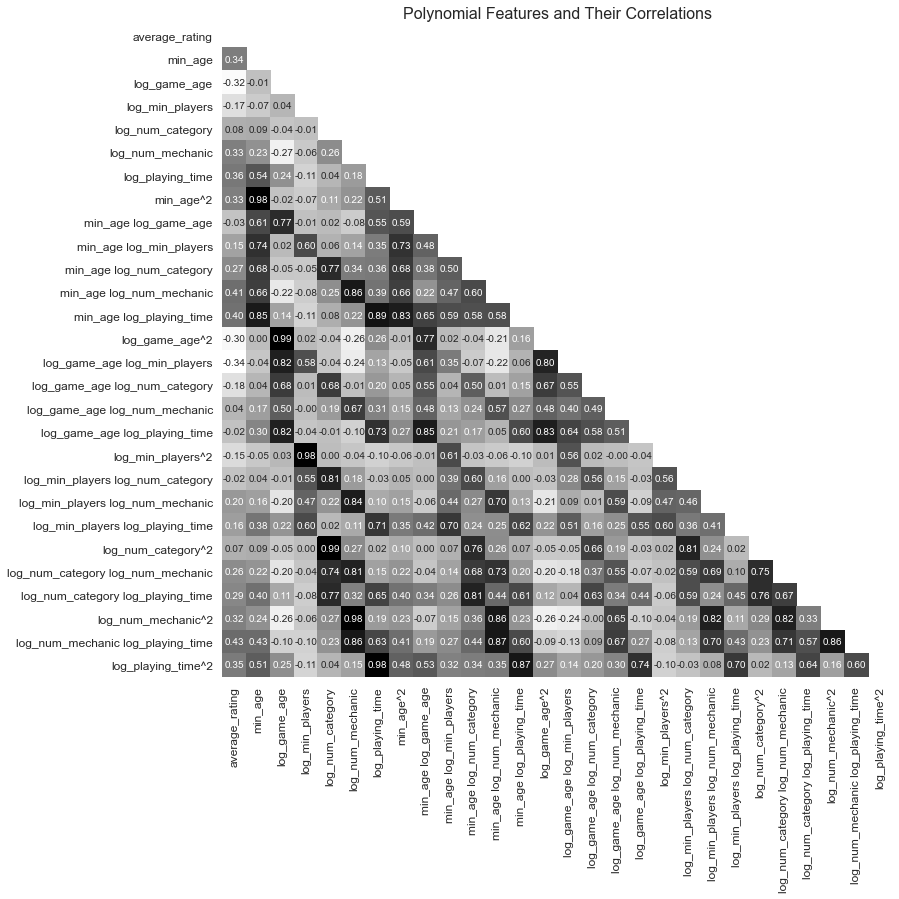

In [41]:
# Plot a heatmap of correlations
with sns.axes_style('white'):
    fig, axes = plt.subplots(figsize=(12,12))
    mask = np.triu(np.ones_like(feat_df.corr(), dtype=bool))
    sns.heatmap(feat_df.corr(),
                mask=mask,
                cmap='binary',
                cbar=False,
                annot=True,
                annot_kws={'size':10},
                fmt='.2f')
    plt.title('Polynomial Features and Their Correlations', fontsize=16)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

plt.savefig("poly_features.png")

## 4. Hypothesis Testing

In [42]:
# Create train set and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=10)
# First look
train.head().T

,2043,10146,8913,1874,8635
max_players,3.000000,5.000000,2.000000,2.000000,4.000000
min_age,12.000000,8.000000,13.000000,12.000000,12.000000
year_published,1973.000000,2016.000000,2014.000000,1986.000000,2013.000000
average_rating,6.831480,7.127700,7.384210,6.818100,7.250870
num_artist,1.000000,1.000000,1.000000,4.000000,2.000000
...,...,...,...,...,...
log_playing_time,3.828641,4.110874,3.828641,5.888878,4.110874
log_min_players,1.098612,1.098612,1.098612,1.098612,1.098612
log_game_age,3.850148,1.386294,1.791759,3.526361,1.945910
log_num_mechanic,0.693147,1.609438,1.386294,1.098612,2.079442


In [43]:
# Examine columns
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5267 entries, 2043 to 2247
Columns: 107 entries, max_players to log_num_category
dtypes: float64(9), int64(98)
memory usage: 4.3 MB


In [44]:
df = train.copy()

,t-value,p-value
category_name,,
children's game,-16.004076,0.000000
war,13.963079,0.000000
component,-9.778298,0.000000
humor,-9.435928,0.000000
animals,-7.386251,0.000000
party game,-5.765460,0.000000
industry / manufacturing,5.553173,0.000000
ancient,5.051196,0.000001
medieval,4.679094,0.000004


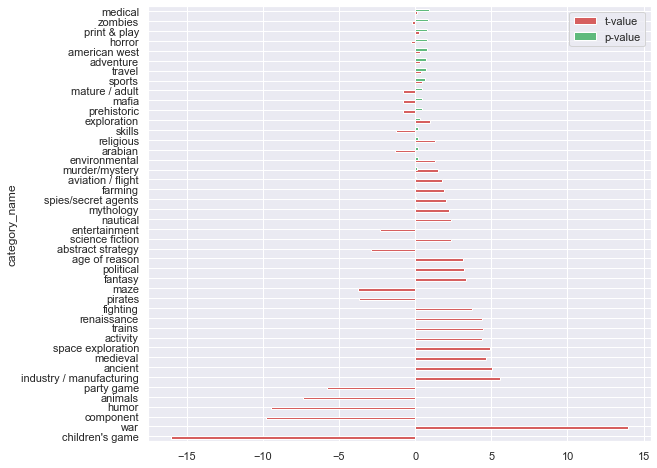

In [45]:
from scipy.stats import ttest_ind, t

# Create a function to conduct Welch's test and plot distributions
def t_ind_test(s1: pd.Series,
               s2: pd.Series,
               equal_var=False) -> tuple:
    """
    Returns t-value and p-value
    """

    dfreedom = len(s1) + len(s2) - 2
    t_val, p_val = ttest_ind(s1, s2, equal_var=equal_var)
    return t_val, p_val

def test_loop(data: pd.DataFrame,
              prefix: str, filename: str) -> pd.DataFrame:
    """
    Returns a table of t test result sorted by p-values 
    with colored bars (green for positive values and red for negative ones)
    """

    category_df = data.filter(regex=prefix, axis=1)
    category = sorted(list(category_df.columns))

    test_results = []
    for i in category:
        non_category_ratings = data[data[i] == 0]['average_rating']
        category_ratings = data[data[i] == 1]['average_rating']
        test_results.append((i.replace(prefix, ''),) + t_ind_test(category_ratings, non_category_ratings))

    test_results_df = (pd.DataFrame(test_results, columns=[prefix + 'name', 't-value', 'p-value'])
                       .sort_values('p-value')
                       .set_index(prefix + 'name')
    )
    
    fig, axes = plt.subplots(figsize=(9,8))
    test_results_df.plot.barh(color=['#d65f5f', '#5fba7d'], ax=axes)
    fig.savefig(filename)
    test_results_df = test_results_df.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])
    
    return test_results_df


test_loop(df, 'category_', filename="hyp_testing_category.png")


,t-value,p-value
mechanic_name,,
area control / area influence,13.388357,0.000000
worker placement,13.011855,0.000000
simulation,11.817451,0.000000
variable player powers,11.171225,0.000000
roll / spin and move,-11.186036,0.000000
deck / pool building,10.718895,0.000000
grid movement,9.312690,0.000000
action point allowance system,8.841405,0.000000
dice rolling,7.706043,0.000000


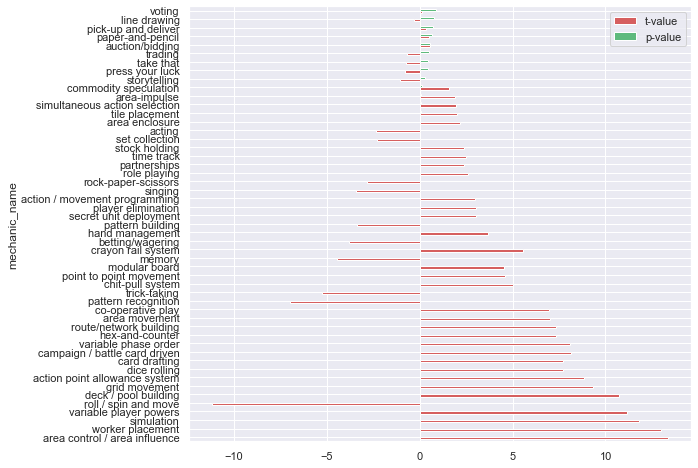

In [46]:

test_loop(df, 'mechanic_', filename="hyp_testing_mechanic.png")
